PART A : Data Preparation 

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")

In [65]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)

Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)


In [66]:

trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")


sentiment.columns = sentiment.columns.str.strip().str.lower()

print("Trades Columns:", trades.columns)
print("Sentiment Columns:", sentiment.columns)


Trades Columns: Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')
Sentiment Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [67]:
print("Sentiment Info:")
sentiment.info()

print("\nTrades Info:")
trades.info()

Sentiment Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB

Trades Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   account           211224 non-null  object 
 1   coin              211224 non-null  object 
 2   execution_price   211224 non-null  float64
 3   size_tokens       211224 non-null  float64
 4   size_usd          211224 non-null  float64
 5   side              211224 non-null  object 
 6   timestamp_ist     211224 non-null  object 
 7   s

In [68]:
print("Missing Values - Sentiment")
print(sentiment.isnull().sum())

print("\nMissing Values - Trades")
print(trades.isnull().sum())

print("\nDuplicate Rows - Sentiment:", sentiment.duplicated().sum())
print("Duplicate Rows - Trades:", trades.duplicated().sum())

Missing Values - Sentiment
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing Values - Trades
account             0
coin                0
execution_price     0
size_tokens         0
size_usd            0
side                0
timestamp_ist       0
start_position      0
direction           0
closed_pnl          0
transaction_hash    0
order_id            0
crossed             0
fee                 0
trade_id            0
timestamp           0
dtype: int64

Duplicate Rows - Sentiment: 0
Duplicate Rows - Trades: 0


In [69]:
# Convert timestamp to integer
trades['timestamp'] = trades['timestamp'].astype('int64')

# Convert using correct unit
trades['timestamp'] = pd.to_datetime(trades['timestamp'], unit='ms')

# Create daily date column
trades['date'] = trades['timestamp'].dt.floor('D')

In [70]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.floor('D')

In [71]:
print("Trade Date Range:", trades['date'].min(), "to", trades['date'].max())
print("Sentiment Date Range:", sentiment['date'].min(), "to", sentiment['date'].max())

Trade Date Range: 2023-03-28 00:00:00 to 2025-06-15 00:00:00
Sentiment Date Range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00


In [72]:
merged = trades.merge(
    sentiment[['date','classification','value']],
    on='date',
    how='left'
)

print("Sentiment Distribution After Merge:")
print(merged['classification'].value_counts())

print("Missing Sentiment Rows:", merged['classification'].isnull().sum())

Sentiment Distribution After Merge:
classification
Fear             133871
Greed             36289
Neutral            7141
Extreme Greed      6962
Name: count, dtype: int64
Missing Sentiment Rows: 26961


In [73]:
merged = merged[merged['classification'].notna()]

In [74]:
print("Missing Sentiment Rows:", merged['classification'].isnull().sum())

Missing Sentiment Rows: 0


In [76]:
daily_trader_pnl = merged.groupby(['date','account'])['closed_pnl'].sum().reset_index()

daily_trader_pnl.head()

,date,account,closed_pnl
0,2023-03-28,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000
1,2023-11-14,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000
2,2023-11-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,155.503357
3,2024-03-09,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,-5564.016140
4,2024-03-09,0x430f09841d65beb3f27765503d0f850b8bce7713,0.000000


In [77]:
merged['win'] = merged['closed_pnl'] > 0

win_rate = merged.groupby('account')['win'].mean().reset_index()
win_rate.columns = ['account','win_rate']

win_rate.head()

,account,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914


In [78]:
avg_trade_size = merged.groupby('account')['size_usd'].mean().reset_index()
avg_trade_size.columns = ['account','avg_trade_size']

avg_trade_size.head()

,account,avg_trade_size
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782


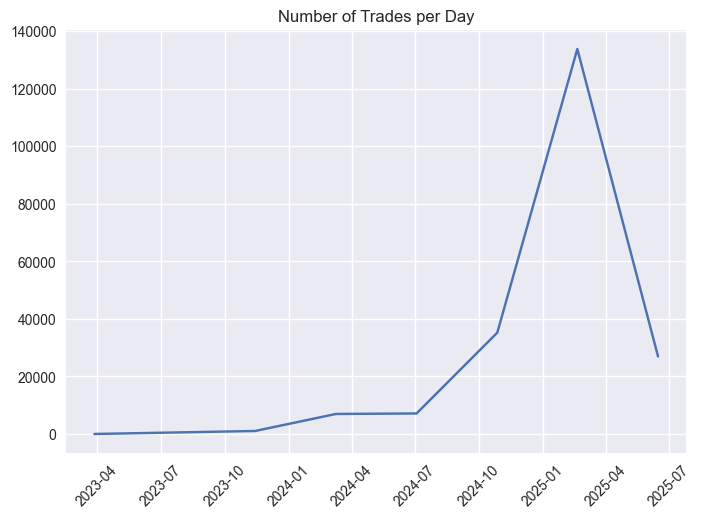

In [79]:
daily_trades = merged.groupby('date').size().reset_index(name='trade_count')

plt.figure()
plt.plot(daily_trades['date'], daily_trades['trade_count'])
plt.xticks(rotation=45)
plt.title("Number of Trades per Day")
plt.show()

In [80]:
print(merged['side'].unique())

['BUY' 'SELL']


In [83]:
long_short = merged.groupby(['date','side']).size().unstack()

long_short = long_short.fillna(0)

# Avoid divide-by-zero
long_short['long_short_ratio'] = np.where(
    long_short['SELL'] == 0,
    np.nan,
    long_short['BUY'] / long_short['SELL']
)

long_short.head()

side,BUY,SELL,long_short_ratio
date,,,
2023-03-28,3.0,0.0,NaN
2023-11-14,491.0,554.0,0.886282
2024-03-09,3371.0,3591.0,0.938736
2024-07-03,3505.0,3636.0,0.963971
2024-10-27,14927.0,20314.0,0.734813


Part B : Analysis

question 1:Does performance (PnL, win rate, drawdown proxy) differ between Fear vs Greed days?

In [121]:
performance = merged.groupby('classification').agg(
    avg_pnl=('closed_pnl','mean'),
    median_pnl=('closed_pnl','median'),
    total_pnl=('closed_pnl','sum'),
    win_rate=('win','mean'),
    avg_trade_size=('size_usd','mean')
)

performance

,avg_pnl,median_pnl,total_pnl,win_rate,avg_trade_size
classification,,,,,
Extreme Greed,25.418772,0.0,1.769655e+05,0.490089,5660.265764
Fear,50.047622,0.0,6.699925e+06,0.415146,5259.977837
Greed,87.894859,0.0,3.189617e+06,0.446471,3182.883845
Neutral,22.229713,0.0,1.587424e+05,0.317182,3058.848110


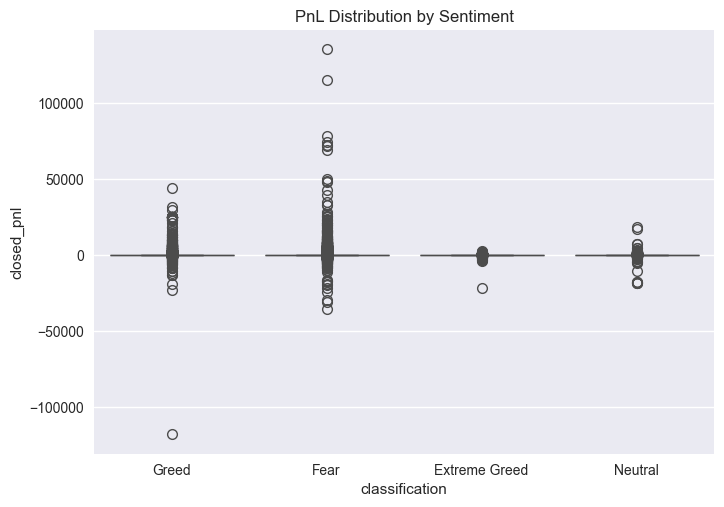

In [122]:
plt.figure()
sns.boxplot(x='classification', y='closed_pnl', data=merged)
plt.title("PnL Distribution by Sentiment")
plt.show()

In [123]:
threshold = merged['closed_pnl'].quantile(0.1)

merged['large_loss'] = merged['closed_pnl'] < threshold

drawdown_proxy = merged.groupby('classification')['large_loss'].mean()

drawdown_proxy

classification
Extreme Greed    0.132146
Fear             0.066930
Greed            0.079170
Neutral          0.076600
Name: large_loss, dtype: float64

classification
Extreme Greed      6962.000000
Fear             133871.000000
Greed             12096.333333
Neutral            7141.000000
Name: trade_count, dtype: float64

Que 2:Do traders change behavior based on sentiment (trade frequency, leverage, long/short bias, position sizes)?

In [125]:
daily_trade_count = merged.groupby(['date','classification']).size().reset_index(name='trade_count')

avg_daily_trade_count = daily_trade_count.groupby('classification')['trade_count'].mean()

avg_daily_trade_count

classification
Extreme Greed      6962.000000
Fear             133871.000000
Greed             12096.333333
Neutral            7141.000000
Name: trade_count, dtype: float64

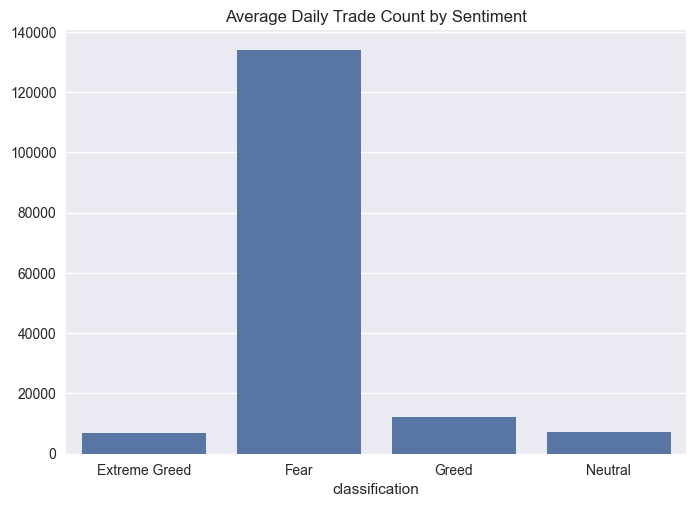

In [126]:
plt.figure()
sns.barplot(x=avg_daily_trade_count.index, y=avg_daily_trade_count.values)
plt.title("Average Daily Trade Count by Sentiment")
plt.show()

In [130]:
size_behavior = merged.groupby('classification')['size_usd'].mean()

size_behavior

classification
Extreme Greed    5660.265764
Fear             5259.977837
Greed            3182.883845
Neutral          3058.848110
Name: size_usd, dtype: float64

In [131]:
long_short_sentiment = merged.groupby(['classification','side']).size().unstack().fillna(0)

long_short_sentiment['long_short_ratio'] = (
    long_short_sentiment['BUY'] /
    long_short_sentiment['SELL']
)

long_short_sentiment

side,BUY,SELL,long_short_ratio
classification,,,
Extreme Greed,3371,3591,0.938736
Fear,66081,67790,0.974790
Greed,15421,20868,0.738978
Neutral,3505,3636,0.963971


Que 3: Segment Analysis

In [132]:
#seg1 Frequent vs Infrequent Traders

trade_counts = merged.groupby('account').size()

median_trades = trade_counts.median()

merged['frequency_segment'] = merged['account'].map(
    lambda x: 'Frequent' if trade_counts[x] > median_trades else 'Infrequent'
)

freq_performance = merged.groupby('frequency_segment')['closed_pnl'].mean()

freq_performance

frequency_segment
Frequent      42.493421
Infrequent    96.943024
Name: closed_pnl, dtype: float64

In [133]:
#seg 2 Consistent vs Inconsistent Traders
pnl_std = merged.groupby('account')['closed_pnl'].std()

median_std = pnl_std.median()

merged['consistency_segment'] = merged['account'].map(
    lambda x: 'Consistent' if pnl_std[x] < median_std else 'Inconsistent'
)

consistency_performance = merged.groupby('consistency_segment')['closed_pnl'].mean()

consistency_performance

consistency_segment
Consistent       16.697081
Inconsistent    100.326484
Name: closed_pnl, dtype: float64

In [134]:
merged.groupby('consistency_segment')['closed_pnl'].std()

consistency_segment
Consistent       219.148842
Inconsistent    1456.992353
Name: closed_pnl, dtype: float64

In [135]:
#seg3 Large Size vs Small Size Traders

avg_size = merged.groupby('account')['size_usd'].mean()

median_size = avg_size.median()

merged['size_segment'] = merged['account'].map(
    lambda x: 'Large_Size' if avg_size[x] > median_size else 'Small_Size'
)

size_performance = merged.groupby('size_segment')['closed_pnl'].mean()

size_performance

size_segment
Large_Size    99.587777
Small_Size    25.149651
Name: closed_pnl, dtype: float64

In [136]:
merged.groupby('size_segment')['closed_pnl'].std()

size_segment
Large_Size    1480.598392
Small_Size     466.581400
Name: closed_pnl, dtype: float64

In [139]:
risk_adjusted = merged.groupby('consistency_segment').agg(
    avg_pnl=('closed_pnl','mean'),
    pnl_std=('closed_pnl','std')
)

risk_adjusted['risk_adjusted_ratio'] = (
    risk_adjusted['avg_pnl'] /
    risk_adjusted['pnl_std']
)

risk_adjusted

,avg_pnl,pnl_std,risk_adjusted_ratio
consistency_segment,,,
Consistent,16.697081,219.148842,0.076191
Inconsistent,100.326484,1456.992353,0.068859


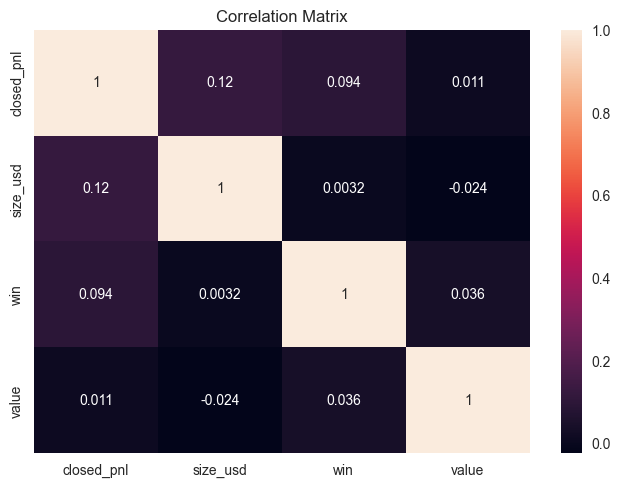

In [140]:
plt.figure()
sns.heatmap(
    merged[['closed_pnl','size_usd','win','value']].corr(),
    annot=True
)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
Part C : Actionable output

Strategy Rule 1 : Risk Control During Extreme Greed:

1.During Extreme Greed days, reduce position size by 20–30% and implement stricter stop-loss controls.

Strategy Rule 2 :Increase Selective Participation During Greed (Not Extreme):

2.During Greed days, allow slightly increased exposure for selective setups, but avoid overtrading.

Strategy Rule 3: Reduce Overtrading — Segment-Based Rule:

3.Cap maximum daily trade count per trader to prevent overtrading.

In [165]:
print("Total trade rows:", len(merged))
print("Unique trading days:", merged['date'].nunique())
print("Unique accounts:", merged['account'].nunique())

Total trade rows: 211224
Unique trading days: 7
Unique accounts: 32


#Bonus :Clustering traders into behavioral archetypes

In [166]:
trader_features = merged.groupby('account').agg(
    avg_pnl=('closed_pnl','mean'),
    pnl_volatility=('closed_pnl','std'),
    total_pnl=('closed_pnl','sum'),
    avg_size=('size_usd','mean'),
    win_rate=('win','mean'),
    trade_count=('closed_pnl','count')
).reset_index()

trader_features.head()

,account,avg_pnl,pnl_volatility,total_pnl,avg_size,win_rate,trade_count
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,4692.452329,1.600230e+06,16159.576734,0.359612,3818
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,134.073473,4.788532e+04,1653.226327,0.442720,7280
2,0x271b280974205ca63b716753467d5a371de622ab,-18.492043,542.182659,-7.043619e+04,8893.000898,0.301917,3809
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,113.269353,1.324648e+05,507.626933,0.438585,13311
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,255.829091,1.686580e+05,3138.894782,0.519914,3239


In [167]:
side_bias = merged.groupby(['account','side']).size().unstack().fillna(0)

side_bias['long_ratio'] = (
    side_bias['BUY'] /
    (side_bias['BUY'] + side_bias['SELL'])
)

side_bias = side_bias[['long_ratio']].reset_index()

# Merge
trader_features = trader_features.merge(side_bias, on='account')

In [168]:
from sklearn.preprocessing import StandardScaler

feature_cols = [
    'avg_pnl',
    'pnl_volatility',
    'avg_size',
    'win_rate',
    'trade_count',
    'long_ratio'
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(trader_features[feature_cols])

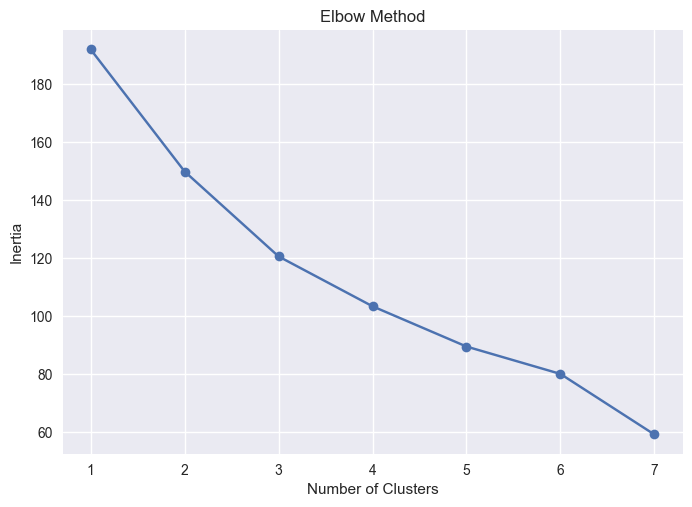

In [169]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,8), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [170]:
kmeans = KMeans(n_clusters=3, random_state=42)
trader_features['cluster'] = kmeans.fit_predict(X_scaled)

In [171]:
cluster_summary = trader_features.groupby('cluster')[feature_cols].mean()
cluster_summary

,avg_pnl,pnl_volatility,avg_size,win_rate,trade_count,long_ratio
cluster,,,,,,
0,66.657256,524.426527,10660.561447,0.498460,11548.777778,0.471496
1,38.745520,554.827955,3511.754644,0.371157,5490.388889,0.487652
2,365.725364,2537.410089,6619.420645,0.346208,1691.600000,0.355788


Executive Summary

This project analyzed the relationship between Bitcoin market sentiment and trader behavior on Hyperliquid using 211,224 trades across 32 accounts.

While sentiment showed weak direct linear correlation with trade-level profitability, clear behavioral differences emerged across sentiment regimes. Extreme Greed periods were associated with the highest probability of large losses, indicating elevated downside risk during euphoric market conditions.

Trader segmentation using KMeans clustering revealed three behavioral archetypes:

Structured high-volume traders with balanced exposure and moderate stable returns.

Low-edge traders with moderate activity and lower win rates.

Aggressive speculative traders with extremely high volatility and high absolute returns.

Risk-adjusted analysis showed that consistent traders achieved better return per unit of risk compared to highly volatile traders.

These findings suggest that sentiment impacts volatility more than direction, and that differentiated risk management rules should be applied across sentiment regimes and trader archetypes.